In [1]:
import torch
import dlc_practical_prologue as prologue
from torch import nn
from torch import optim
import matplotlib.pyplot as plt #To remove (use matplotlib)
from torch.nn import functional as F
from torch.autograd import Variable

import numpy as np

In [2]:
def print_image(im):        #To remove (use matplotlib)
    plt.imshow(im, cmap='gray')
    plt.show()

## Importing data

In [3]:
def import_data(N, normalize):
    train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N)
    if (normalize):
        train_input = (train_input - train_input.mean())/train_input.std()
        test_input = (test_input - train_input.mean())/train_input.std()
    return (train_input, train_target, train_classes, test_input, test_target, test_classes)

def make_one_hot(vector):
    one_hot = torch.zeros(( vector.size(0) , int(vector.max())+1 ))
    for i in range(0, vector.size(0)):
        one_hot[i, vector[i]] = 1
    return one_hot
    

In [4]:
N = 1000 #num
train_input, train_target, train_classes, test_input, test_target, test_classes = import_data(N, True)
train_target_one_hot = make_one_hot(train_target)
test_target_one_hot = make_one_hot(test_target)
train_classes_one_hot = make_one_hot(train_classes[:,0])
test_classes_one_hot = make_one_hot(test_classes[:,0])


print(train_input.size())

torch.Size([1000, 2, 14, 14])


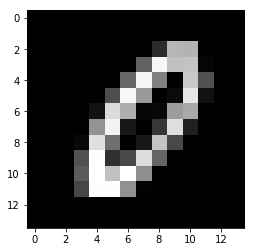

In [5]:
print_image(train_input[364,0,:,:])

#blub = make_one_hot(train_target)
#blib = make_one_hot(train_classes[:,0])

#print(blub)
#print(blib)


## Identifying Images and doing substraction (Aborter)

In [6]:
 
    
def compute_nb_errors(model, data_input, data_target):
    mini_batch_size = 100
    error = 0
    for b in range(0, data_input.size(0), mini_batch_size):
        output = model(data_input[b : b + mini_batch_size])
        _, output = torch.max(output, dim = 1)
        
        if data_target.dim() == 2: #Switch from one hot to normal
            _, target = torch.max(data_target[b : b + mini_batch_size], dim = 1)
        else: 
            target = data_target[b : b + mini_batch_size]
            
        error += int( (output - target).abs().sum())
    return( error )



## Same network as Natalie: no auxiliary losses

In [7]:
class No_aux_losses(nn.Module):
    def __init__(self, nb_hidden):
        super(No_aux_losses, self).__init__()
        self.conv1 = nn.Conv2d(1*2, 32*2, kernel_size=5)
        self.conv2 = nn.Conv2d(32*2, 64*2, kernel_size=5)
        self.fcA1 = nn.Linear(1024*2, nb_hidden*2)
        self.fcA2 = nn.Linear(nb_hidden*2, 2*10)
        self.fcB1 = nn.Linear(20, 100)
        self.fcB2 = nn.Linear(100,200)
        self.fcB3 = nn.Linear(200, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=1))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=1))
        x = F.relu(self.fcA1(x.view(-1, 1024*2)))
        x = self.fcA2(x)
        x = F.relu(self.fcB1(x))
        x = F.relu(self.fcB2(x))
        x = self.fcB3(x)
        return x    
    
def train_model_no_aux_losses(model, train_input, train_target, epochs=25, \
                mini_batch_size=100, lr=1e-3, criterion=None, optimizer=None, verbose=2, return_rate=False):
    
    print('Training network with no auxiliary losses')
    
    # use MSE loss by default
    if not criterion:
        criterion = nn.MSELoss()
    
    # use SGD by default
    if not optimizer:
        optimizer = optim.SGD(model.parameters(), lr = lr)

    if return_rate:
        nb_error = torch.zeros(epochs)
        loss_list = torch.zeros(epochs)
    
    for e in range(epochs):
        sum_loss = 0
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size))
            
            #print(train_input.narrow(0, b, mini_batch_size).size())
            #print(output.size())
            #print(train_target.narrow(0, b, mini_batch_size).size())
            
            loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
            model.zero_grad()
            loss.backward()
            sum_loss = sum_loss + loss.item()
            with torch.no_grad():
                optimizer.step()
                
            if return_rate:
                nb_error[e] = compute_nb_errors(model, train_input, train_target)
                loss_list[e] = sum_loss
                
            #for p in model.parameters():
            #    p.data.sub_(lr * p.grad.data)
        
        if verbose == 0: print('Epoch: {}, loss: {:0.2f}'.format(e, sum_loss))
        elif verbose == 1 and e%5 == 0: print(e, sum_loss)
            
    if return_rate:
        return((nb_error.view(-1), loss_list.view(-1)))

In [8]:
model_no_aux_losses = No_aux_losses(200)
train_model_no_aux_losses(model_no_aux_losses, train_input, train_target_one_hot, verbose=1,\
                          epochs = 4)

out = model_no_aux_losses(test_input)

print(compute_nb_errors(model_no_aux_losses, train_input, train_target))
print(compute_nb_errors(model_no_aux_losses, test_input, test_target))

Training network with no auxiliary losses
0 5.04946506023407
531
474


In [9]:
#print(model_no_aux_losses.fcA1.weight)
#print(model_no_aux_losses.fcA1.bias)

In [10]:
model_no_aux_losses = No_aux_losses(200)
nb_error, loss_list = train_model_no_aux_losses(model_no_aux_losses, train_input, train_target_one_hot, verbose=1,\
                                    epochs = 4, return_rate=True)



Training network with no auxiliary losses
0 5.017877221107483


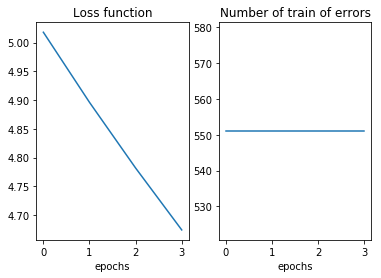

In [11]:
##Plot kinda nicely

plt.figure(1)
plt.subplot(1,2,1)
plt.xlabel("epochs")
plt.title("Loss function")
plt.plot(np.arange(0,loss_list.size(0)) , loss_list.numpy())
plt.subplot(1,2,2)
plt.plot(np.arange(0,nb_error.size(0)) , nb_error.numpy())
plt.xlabel("epochs")
plt.title("Number of train of errors")
plt.show()




In [12]:
nb_error.size()

torch.Size([4])

## Test structure with cross-validation

Training network with no auxiliary losses
0 4.987229615449905
5 4.224190354347229
10 3.637840449810028
15 3.1798821687698364
20 2.8343028128147125
Training network with no auxiliary losses
0 5.006651401519775
5 4.378711640834808
10 3.859232008457184
15 3.349735766649246
20 2.9053654968738556


/home/sami/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Training network with no auxiliary losses
0 5.2182934284210205
5 4.484877437353134
10 3.9814800918102264
15 3.5692388117313385
20 3.2111054956912994
Training network with no auxiliary losses
0 4.411982089281082
5 3.986612945795059
10 3.638170063495636
15 3.3416267037391663
20 3.081218957901001
Training network with no auxiliary losses
0 4.975440710783005
5 4.414161205291748
10 3.9365211129188538
15 3.5229969024658203
20 3.124952584505081
Training network with no auxiliary losses
0 5.523628890514374
5 4.83789137005806
10 4.3091117441654205
15 3.868213325738907
20 3.4881878197193146
Training network with no auxiliary losses
0 5.166383326053619
5 4.4724584221839905
10 3.9547874331474304
15 3.5013854801654816
20 3.1075641810894012
Training network with no auxiliary losses
0 4.770033091306686
5 4.104408025741577
10 3.5870316326618195
15 3.1198178827762604
20 2.7448845505714417
Training network with no auxiliary losses
0 4.918587923049927
5 4.244580805301666
10 3.7449739277362823
15 3.372630

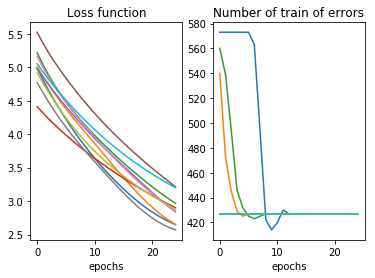

In [14]:
number_of_test = 10
N = 1000 #num
valid_length = int(N/number_of_test)
epochs = 25

nb_error_list = torch.zeros(number_of_test, epochs)
loss_list = torch.zeros(number_of_test, epochs)

train_input, train_target, train_classes, test_input, test_target, test_classes = import_data(N, True)
train_target_one_hot = make_one_hot(train_target)
test_target_one_hot = make_one_hot(test_target)
train_classes_one_hot = make_one_hot(train_classes[:,0])
test_classes_one_hot = make_one_hot(test_classes[:,0])

for test in range(0,number_of_test):
    model_no_aux_losses = No_aux_losses(200)
    
    train_input_i = torch.cat( (train_input[0:test*valid_length,:,:,:] ,train_input[(test+1)*valid_length:,:,:,:]) ,0)
    valid_input_i = train_input[test*valid_length:(test+1)*valid_length,:,:,:]
    train_target_i = torch.cat( (train_target_one_hot[0:test*valid_length,:] ,train_target_one_hot[(test+1)*valid_length:,:]) ,0)
    valid_target_i = train_target_one_hot[test*valid_length:(test+1)*valid_length,:]
    
    nb_error_list[test, :], loss_list[test, :] = train_model_no_aux_losses(model_no_aux_losses, train_input, train_target_one_hot, verbose=1,\
                                    epochs=epochs, return_rate=True)
    plt.figure(1)
    plt.subplot(1,2,1)
    plt.xlabel("epochs")
    plt.title("Loss function")
    plt.plot(np.arange(0,loss_list.size(1)) , loss_list[test,:].numpy())
    plt.subplot(1,2,2)
    plt.plot(np.arange(0,nb_error_list.size(1)) , nb_error_list[test,:].numpy())
    plt.xlabel("epochs")
    plt.title("Number of train of errors")
    
    
    
plt.show()



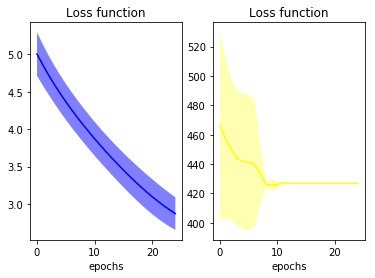

In [15]:

plt.figure
plt.subplot(1,2,1)
plt.plot(np.arange(0,loss_list.size(1)) , loss_list.mean(0).numpy(), color='blue')
plt.fill_between(np.arange(0,loss_list.size(1)) , loss_list.mean(0).numpy()+loss_list.std(0).numpy(), loss_list.mean(0).numpy()-loss_list.std(0).numpy(), facecolor='blue', alpha=0.5)
plt.xlabel("epochs")
plt.title("Loss function")

plt.subplot(1,2,2)
plt.plot(np.arange(0,nb_error_list.size(1)) , nb_error_list.mean(0).numpy(),color='yellow')
plt.fill_between(np.arange(0,nb_error_list.size(1)) , nb_error_list.mean(0).numpy()+nb_error_list.std(0).numpy(), nb_error_list.mean(0).numpy()-nb_error_list.std(0).numpy(), facecolor='yellow', alpha=0.3)
plt.xlabel("epochs")
plt.title("Loss function")
plt.show()

In [107]:
A = torch.tensor([[1,2],[3,5]])
print(torch.cat((A,A),0))

tensor([[1, 2],
        [3, 5],
        [1, 2],
        [3, 5]])
